In [1]:
library(igraph)
library(data.table)
library(rjson)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [2]:
edge_file = "san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv"
json_file = "san_francisco_censustracts.json"

In [3]:
edge_list = read.csv(file = edge_file, header = TRUE, sep = ",")

In [4]:
edge_table = as.data.table(edge_list)

In [5]:
edge_data = edge_table[month == 12][, c("sourceid", "dstid", "mean_travel_time")]

In [6]:
json_data = fromJSON(file = json_file)

In [7]:
features = json_data $ features
len = length(features)

In [8]:
id_list = c()
x_list = c()
y_list = c()
dist_list = c()
loc_list = list()

for(i in 1:len){
    feature = features[[i]]
    dist_list = c(dist_list, feature$properties$DISPLAY_NAME)
    location = feature$geometry$coordinates
    location_list = split(unlist(location), 1:2)
    avg_x = mean(location_list[[1]])
    avg_y = mean(location_list[[2]])
    x_list = c(x_list, avg_x)
    y_list = c(y_list, avg_y)
    loc = c()
    loc = c(loc, avg_x)
    loc = c(loc, avg_y)
    loc_list[[i]] = loc
    id_list = c(id_list, feature$properties$MOVEMENT_ID)
}


In [9]:
g = graph.data.frame(d = edge_data, directed = FALSE)

In [10]:
g

IGRAPH ce07e7a UN-- 1887 538998 -- 
+ attr: name (v/c), mean_travel_time (e/n)
+ edges from ce07e7a (vertex names):
 [1] 1938--1952 1747--629  1872--1919 1871--1929 81  --2319 1873--1909
 [7] 232 --809  1891--1729 2423--62   650 --1829 680 --1529 542 --2251
[13] 604 --1631 660 --1729 1329--1917 2421--82   1736--739  2021--1192
[19] 550 --2171 1721--1308 1700--1518 176 --2145 1721--889  536 --2311
[25] 74  --2466 288 --326  169 --2215 99  --2216 1755--549  646 --1211
[31] 2315--528  2322--458  2307--608  1390--111  641 --1261 1872--1946
[37] 2357--108  1454--64   1729--809  2355--128  722 --1207 2307--612 
[43] 98  --2226 1074--464  1058--624  614 --1531 151 --2395 2341--268 
+ ... omitted several edges

In [11]:
id2dist = as.list(setNames(dist_list, id_list))

In [12]:
V(g)$DISPLAY = id2dist[V(g)$name]

In [13]:
id2x = as.list(setNames(x_list, id_list))
id2y = as.list(setNames(y_list, id_list))

In [14]:
V(g)$loc_x = id2x[V(g)$name]
V(g)$loc_y = id2y[V(g)$name]

In [15]:
id2loc = as.list(setNames(loc_list, id_list))

In [16]:
V(g)$loc = id2loc[V(g)$name]

In [17]:
g = simplify(g, remove.multiple = TRUE, edge.attr.comb = "mean" )

In [18]:
clusters = components(g)


In [19]:
gcc = induced.subgraph(g, which(clusters$membership == which.max(clusters$csize)))

In [20]:
G = gcc

In [143]:
#not related to the project just transformation to csv
edge_list_G = get.edgelist(G)
weight_G = as.vector(E(G)$mean_travel_time)
edge_weight_list_G = cbind(edge_list_G, weight_G)
write.csv(edge_weight_list_G, file="edge_list_G.csv", row.names=FALSE)


In [159]:
#not related to the project just transformation to csv
name = as.vector(V(G)$name)
DISPLAY = as.vector(V(G)$DISPLAY)
Loc_x = as.vector(V(G)$loc_x)
Loc_y = as.vector(V(G)$loc_y)
vertex_list = cbind(name, DISPLAY, Loc_x, Loc_y)
write.table(vertex_list, file="vertex_list_G.txt", row.names=FALSE,sep="|")

In [21]:
#P6
vcount(G)

[1] 1880

In [22]:
ecount(G)

[1] 311802

In [23]:
#p7
mst = mst(G, weights = E(G)$mean_travel_time)

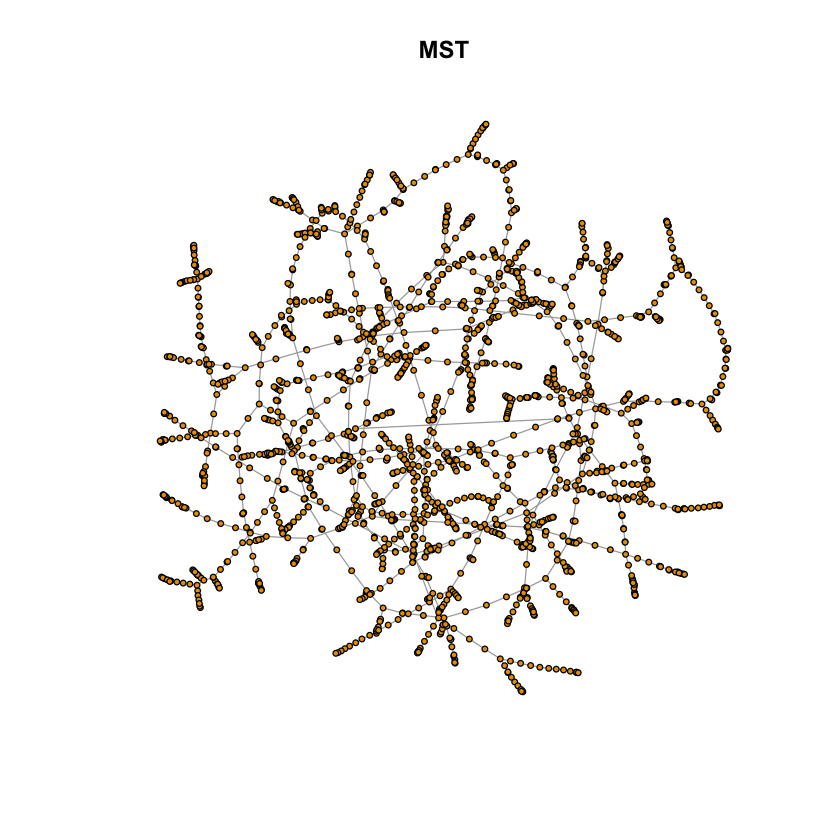

In [24]:
plot(mst, vertex.color = rep(1, vcount(G)), vertex.size = rep(2, vcount(G)), vertex.label = NA, main="MST")

In [149]:
E(G)[get.edge.ids(g, c('1938','700'))]$mean_travel_time

[1] 126.24

In [25]:
adj_mat = as_adjacency_matrix(G, type = "both", attr = "mean_travel_time")

In [26]:
E(G)

+ 311802/311802 edges from 613390b (vertex names):
 [1] 1938--1747 1938--1872 1938--1873 1938--232  1938--1891 1938--550 
 [7] 1938--1721 1938--176  1938--74   1938--1755 1938--1946 1938--1729
[13] 1938--722  1938--234  1938--251  1938--544  1938--1856 1938--338 
[19] 1938--175  1938--687  1938--818  1938--695  1938--682  1938--817 
[25] 1938--153  1938--272  1938--1455 1938--876  1938--131  1938--2147
[31] 1938--396  1938--2146 1938--2155 1938--52   1938--1269 1938--123 
[37] 1938--155  1938--235  1938--702  1938--1284 1938--1925 1938--2613
[43] 1938--1907 1938--1952 1938--1933 1938--957  1938--1906 1938--2513
[49] 1938--2515 1938--1870 1938--1928 1938--1923 1938--1597 1938--104 
[55] 1938--2488 1938--1893 1938--1875 1938--184  1938--65   1938--2169
+ ... omitted several edges

In [29]:
#P8 check Triangle Inequality
check_ineql <- function(G){ 
count = 0
iter = 0
print("start")
while(iter < 1000){
    v1 = sample(V(G), 1)[[1]]$name
    v2 = sample(V(G), 1)[[1]]$name
    v3 = sample(V(G), 1)[[1]]$name
    if(v1 != v2 && v2 != v3 && v1 != v3){
        a = adj_mat[v1,v2]
        b = adj_mat[v2,v3]
        c = adj_mat[v1,v3]
        if(a * b * c != 0){
            if((a > b + c) || (b > a + c) || (c > a + b)) count = count + 1
            iter = iter + 1
        }    
    }  
}
    return(count)
}

In [30]:
ineql = check_ineql(G)

[1] "start"


In [31]:
ratio = ineql / 1000

In [32]:
1 - ratio

[1] 0.926

In [27]:
mst

IGRAPH 027497f UN-- 1880 1879 -- 
+ attr: name (v/c), DISPLAY (v/x), loc_x (v/x), loc_y (v/x), loc (v/x),
| mean_travel_time (e/n)
+ edges from 027497f (vertex names):
 [1] 1938--1241 1938--700  1938--2631 1747--1455 1747--528  1747--1746
 [7] 1872--563  1871--563  1871--1381 1871--390  81  --1701 81  --1295
[13] 81  --1772 1873--2488 232 --2155 232 --2513 1891--1868 2423--169 
[19] 2423--387  2423--602  2423--1086 650 --1703 650 --206  680 --1748
[25] 680 --1461 542 --2700 542 --2503 542 --543  604 --1595 604 --1102
[31] 660 --1296 660 --1776 660 --967  1329--1311 1329--824  2421--2225
[37] 2421--2214 1736--2251 1736--1737 2021--1180 2021--2066 550 --702 
+ ... omitted several edges

In [38]:
mst_directed = as.directed(mst, 'mutual')

In [39]:
mst_double = as.undirected(mst_directed, 'each')

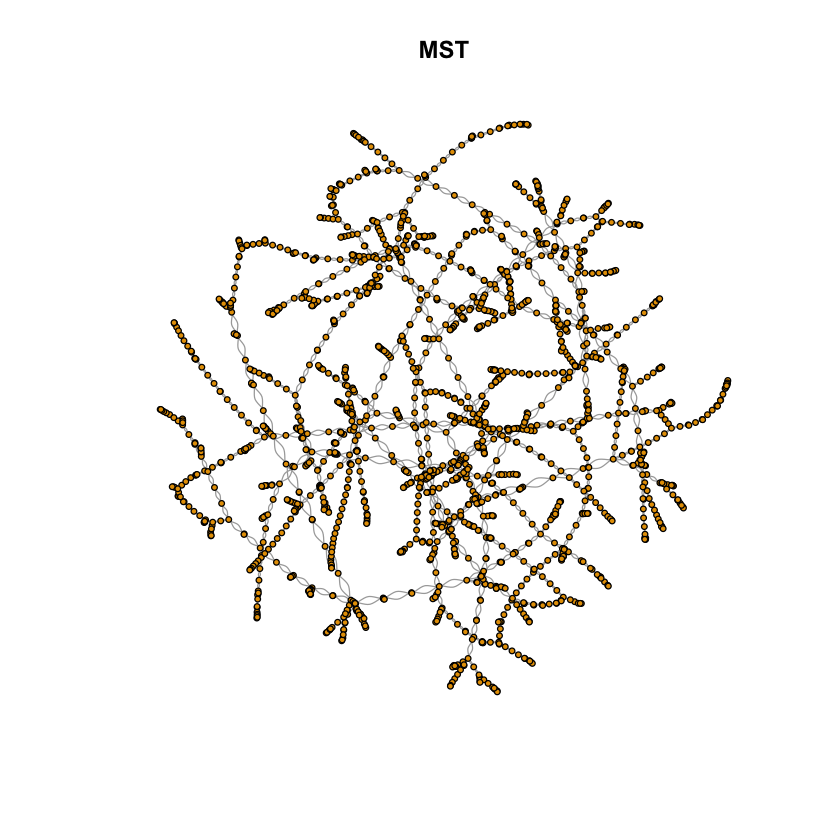

In [40]:
plot(mst_double, vertex.color = rep(1, vcount(G)), vertex.size = rep(2, vcount(G)), vertex.label = NA, main="MST")

In [28]:
edge_list = get.edgelist(mst_double)

ERROR: Error in "igraph" %in% class(graph): object 'mst_double' not found


In [52]:
weight_mst_double = as.vector(E(mst_double)$mean_travel_time)

In [54]:
edge_weight_list = cbind(edge_list, weight_mst_double)

In [56]:
write.csv(edge_weight_list, file="edge_list.csv", row.names=FALSE)

In [41]:
lower_bound = sum(E(mst)$mean_travel_time)

In [42]:
lower_bound

[1] 279408.2

In [43]:
upper_bound = sum(E(mst_double)$mean_travel_time)

In [44]:
upper_bound

[1] 558816.4

In [29]:
tsp_tour = read.table('tsp_tour.txt')

In [30]:
tsp_path = as.vector(tsp_tour[,1])

In [31]:
tsp_order = unique(tsp_path)

In [32]:
tsp_order[1]

[1] 1938

In [33]:
tsp_order[1700]

[1] 409

In [34]:
adj_mat[toString(tsp_order[1]), toString(tsp_order[1700])]

[1] 0

In [104]:
distances(G, toString(tsp_order[1]), toString(tsp_order[2]), weights = E(G)$mean_travel_time)

,1241
1938,132.59


In [35]:
approximate_2_sum = 0
for(i in 2:length(tsp_order)){
    dist = adj_mat[toString(tsp_order[i]), toString(tsp_order[i - 1])]
    if(dist == 0)
        dist = distances(G, toString(tsp_order[i]), toString(tsp_order[i - 1]), weights = E(G)$mean_travel_time)
    approximate_2_sum = approximate_2_sum + dist
}

In [36]:
approximate_2_sum


,1980
252,464500.5


In [45]:
approximate_2_sum / upper_bound

,1980
252,0.8312221


In [76]:
as.numeric(V(G)[toString(tsp_order[2])]$loc_y) 

[1] 37.28098

In [81]:
V(G)['2259']$loc_y

[[1]]
[1] 36.59124

In [83]:
Loc_X = numeric()
Loc_Y = numeric()
for(i in 1:length(tsp_order)){
    Loc_X = c(Loc_X, as.numeric(V(G)[toString(tsp_order[i])]$loc_x))
    Loc_Y = c(Loc_Y, as.numeric(V(G)[toString(tsp_order[i])]$loc_y))
}

In [52]:
install.packages("ggplot2")

also installing the dependencies ‘colorspace’, ‘assertthat’, ‘utf8’, ‘Rcpp’, ‘RColorBrewer’, ‘dichromat’, ‘munsell’, ‘labeling’, ‘viridisLite’, ‘cli’, ‘pillar’, ‘rlang’, ‘gtable’, ‘plyr’, ‘reshape2’, ‘scales’, ‘tibble’, ‘lazyeval’




  There is a binary version available but the source version is later:
     binary source needs_compilation
utf8  1.1.3  1.1.4              TRUE


The downloaded binary packages are in
	/var/folders/ct/l4jp_f0d1cndh0kdh86h1drc0000gn/T//Rtmp4pVc87/downloaded_packages


installing the source package ‘utf8’



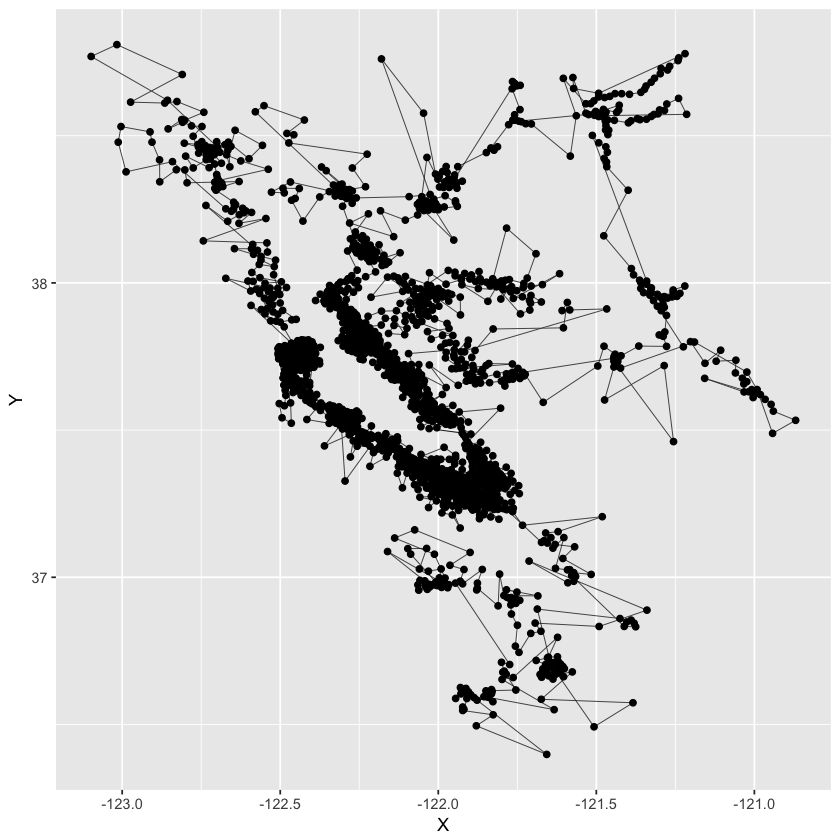

In [166]:
library("ggplot2")
library(grid) # needed for arrow function
library(data.table)
# see http://docs.ggplot2.org/current/geom_segment.html
df <- data.frame(X=Loc_X,Y=Loc_Y,color = 't1', group = 't1')
qplot(X, Y, data = df)+ geom_point(alpha = 0.05, shape='.', size=1) +
        geom_path(linetype=1, size=0.2)
        